<a href="https://colab.research.google.com/github/ptsurko/ml-notebooks/blob/master/C4_Week_3_Exercise_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install tf-nightly-2.0-preview


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


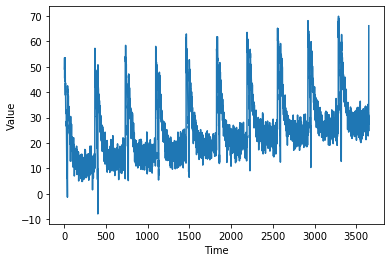

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 128
shuffle_buffer_size = 1000

x_valid_window = series[split_time-window_size:]
time_valid_window = time[split_time-window_size:]

plot_series(time, series)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

def windowed_val_dataset(series, window_size, shuffle_buffer):
  val_dataset = tf.data.Dataset.from_tensor_slices(series)
  val_dataset = val_dataset.window(window_size + 1, shift=1, drop_remainder=True)
  val_dataset = val_dataset.flat_map(lambda window: window.batch(window_size + 1))
  val_dataset = val_dataset.map(lambda window: (window[:-1][np.newaxis], window[-1]))
  val_dataset = val_dataset.shuffle(shuffle_buffer)
  return val_dataset

#DNN

In [0]:
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_dataset = windowed_val_dataset(x_valid_window, window_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(window_size, input_shape=(window_size,), activation="relu"),
  # tf.keras.layers.Dense(20, activation='relu'),
  # tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
])

model.compile(loss='mae',
              optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))

history = model.fit(dataset, epochs=300, verbose=0, validation_data=val_dataset)

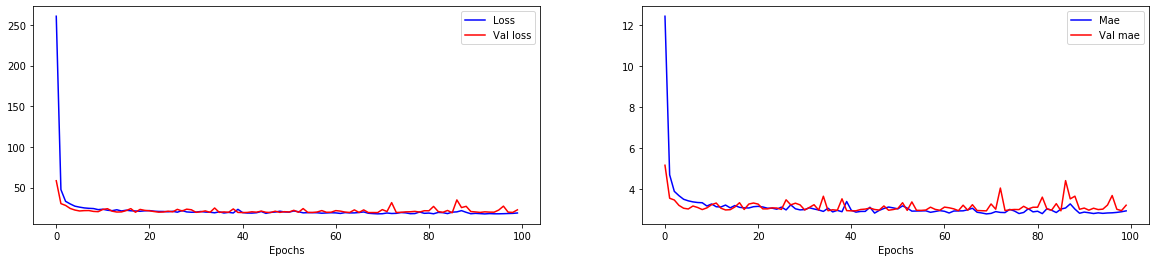

In [23]:
epochs=len(history.history['loss'])

plt.figure(figsize=(20,4))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), history.history['loss'], 'b', label='Loss')
plt.plot(range(epochs), history.history['val_loss'], 'r', label='Val loss')
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history.history['mae'], 'b', label='Mae')
plt.plot(range(epochs), history.history['val_mae'], 'r', label='Val mae')
plt.xlabel("Epochs")
plt.legend()

plt.show()

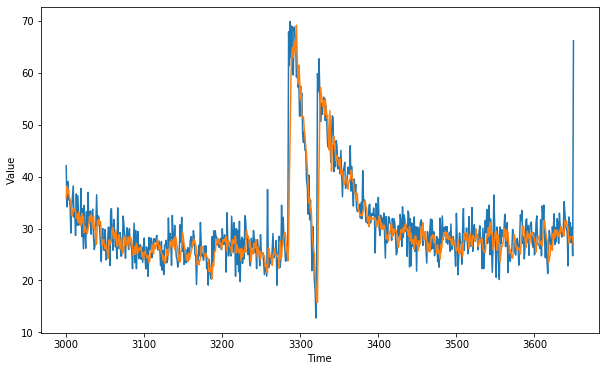

In [0]:
forecast = []
results = []
for time1 in range(len(series) - window_size):
  forecast.append(model.predict(series[time1:time1 + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

3.0868187

# RNN

In [0]:
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, -1)),
  tf.keras.layers.SimpleRNN(units=20, return_sequences=True),
  tf.keras.layers.SimpleRNN(units=20),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=300, callbacks=[lr_schedule], verbose=0)

[1e-08, 0.01, 0, 30]

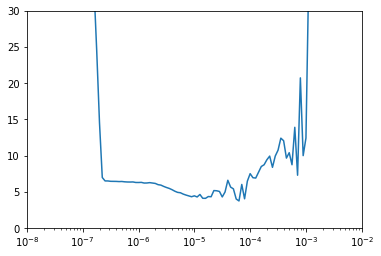

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [0]:
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_dataset = windowed_val_dataset(x_valid_window, window_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, -1)),
  tf.keras.layers.SimpleRNN(units=20, return_sequences=True),
  tf.keras.layers.SimpleRNN(units=20),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),
              metrics=["mae"])
history = model.fit(dataset, epochs=200, verbose=1, validation_data=val_dataset)
model.summary()

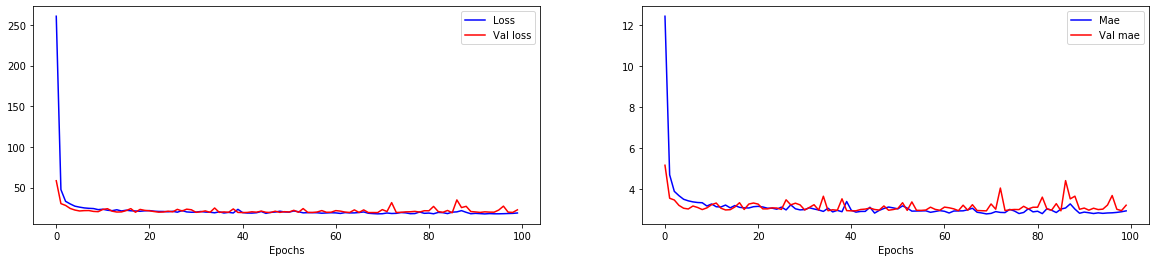

In [24]:
epochs=len(history.history['loss'])

plt.figure(figsize=(20,4))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), history.history['loss'], 'b', label='Loss')
plt.plot(range(epochs), history.history['val_loss'], 'r', label='Val loss')
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history.history['mae'], 'b', label='Mae')
plt.plot(range(epochs), history.history['val_mae'], 'r', label='Val mae')
plt.xlabel("Epochs")
plt.legend()

plt.show()

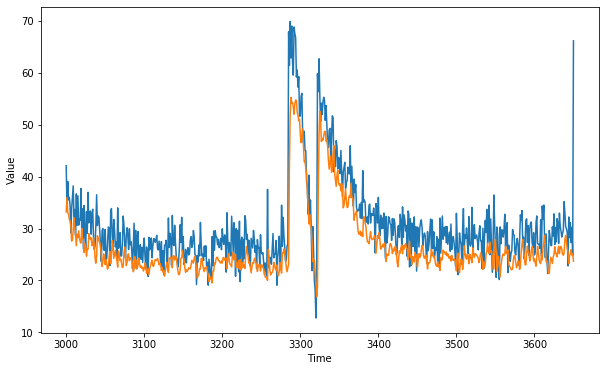

In [9]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

4.410656

# LSTM

In [22]:
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset, epochs=5, callbacks=[lr_schedule], verbose=1)
model.summary()

Epoch 1/5
24/24 [==============================] - 4s 147ms/step - loss: 8.6656 - mae: 9.2205
Epoch 2/5
24/24 [==============================] - 0s 21ms/step - loss: 8.5262 - mae: 9.0756
Epoch 3/5
24/24 [==============================] - 0s 19ms/step - loss: 8.3960 - mae: 8.9111
Epoch 4/5
24/24 [==============================] - 0s 20ms/step - loss: 8.2117 - mae: 8.7451
Epoch 5/5
24/24 [==============================] - 0s 20ms/step - loss: 8.0143 - mae: 8.5855
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_18 (Lambda)           multiple                  0         
_________________________________________________________________
bidirectional_14 (Bidirectio multiple                  8704      
_________________________________________________________________
bidirectional_15 (Bidirectio multiple                  24832     
__________________________________________________

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse",
              optimizer=tf.keras.optimizers.SGD(lr=1e-3, 
                                                momentum=0.9),
              metrics=["mae"])
history = model.fit(dataset,epochs=100,verbose=1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

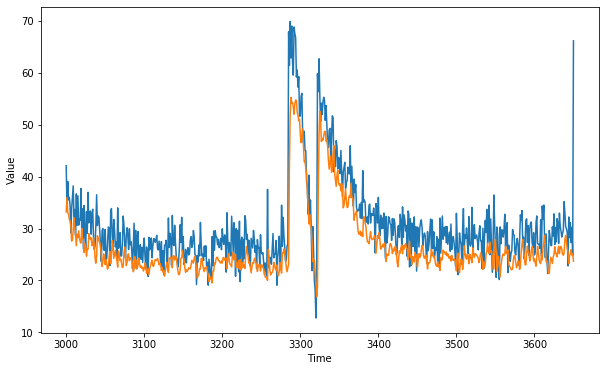

In [11]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

In [0]:
# Resources:
# https://machinelearningmastery.com/cnn-long-short-term-memory-networks/

# CNN

In [7]:
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_dataset = windowed_val_dataset(x_valid_window, window_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu'),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=1, validation_data=val_dataset)
model.summary()

Epoch 1/100
24/24 [==============================] - 8s 320ms/step - loss: 254.1068 - mae: 12.4209 - val_loss: 58.4224 - val_mae: 5.1443
Epoch 2/100
24/24 [==============================] - 4s 148ms/step - loss: 46.6716 - mae: 4.6784 - val_loss: 30.2680 - val_mae: 3.5332
Epoch 3/100
24/24 [==============================] - 4s 151ms/step - loss: 32.8016 - mae: 3.8705 - val_loss: 28.0623 - val_mae: 3.4483
Epoch 4/100
24/24 [==============================] - 4s 149ms/step - loss: 29.3796 - mae: 3.6590 - val_loss: 24.3027 - val_mae: 3.1847
Epoch 5/100
24/24 [==============================] - 4s 151ms/step - loss: 28.1449 - mae: 3.4831 - val_loss: 22.3756 - val_mae: 3.0456
Epoch 6/100
24/24 [==============================] - 4s 149ms/step - loss: 26.1247 - mae: 3.4072 - val_loss: 21.2383 - val_mae: 3.0096
Epoch 7/100
24/24 [==============================] - 4s 151ms/step - loss: 25.7250 - mae: 3.3560 - val_loss: 21.6690 - val_mae: 3.1536
Epoch 8/100
24/24 [==============================] - 

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


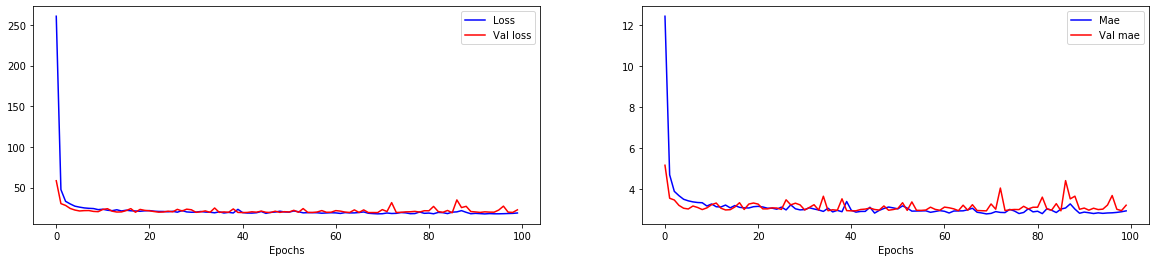

In [22]:
epochs=len(history.history['loss'])

plt.figure(figsize=(20,4))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), history.history['loss'], 'b', label='Loss')
plt.plot(range(epochs), history.history['val_loss'], 'r', label='Val loss')
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history.history['mae'], 'b', label='Mae')
plt.plot(range(epochs), history.history['val_mae'], 'r', label='Val mae')
plt.xlabel("Epochs")
plt.legend()

plt.show()

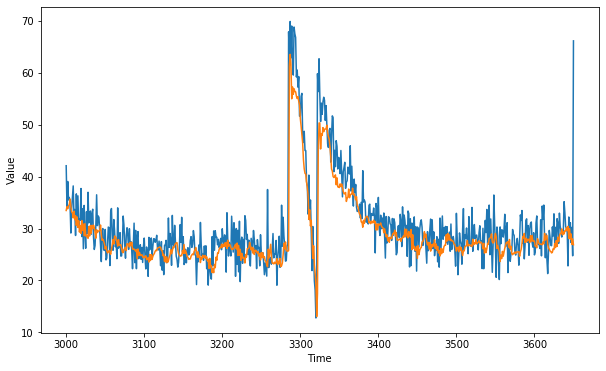

In [26]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [27]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

3.193299